# Task1
- Match clients with agents to maximise the likelihood of completing a transaction. 
- Each agent has their specialized knowledge such as regions, communities and house types. 
- The goal is to leverage this specialized knowledge to optimize the matching process between clients and agents.

# Agenda

1. [Task1](#task1)
   - [Agenda](#agenda)
   - [Idea](#idea)
   - [Problem](#problem)
2. [EDA & Data Preprocessing](#eda--data-preprocessing)
   - [1. Property data](#1-property-data)
     - [Missing data handling](#missing-data-handling)
     - [Data preprocessing](#data-preprocessing)
     - [Feature engineering](#feature-engineering)
     - [Data imputation](#data-imputation)
   - [2. Agent transaction data](#2-agent-transaction-data)
3. [Train Test Split](#train-test-split)
4. [K-Means Clustering](#k-means-clustering)
   - [Encode for cat features](#encode-for-cat-features)
   - [Standardize the num features](#standardize-the-num-features)
   - [Elbow method to find the n_clusters](#elbow-method-to-find-the-n_clusters)
5. [Candidate Generation](#candidate-generation)
6. [Candidate Retrieval](#candidate-retrieval)
7. [Hybrid Method: Content-based Filtering + User-based Collaborative Filtering](#hybrid-method-content-based-filtering--user-based-collaborative-filtering)
   - [0. Client-Agent Scoring Matrices](#0-client-agent-scoring-matrices)
   - [1. Content-based Filtering [Candidate Generation]](#1-content-based-filtering-candidate-generation)
   - [2. User-based Collaborative Filtering [Candidate Retrieval]](#2-user-based-collaborative-filtering-candidate-retrieval)
     - [2a. Cosine Similarity (user-based: row-wise)](#2a-cosine-similarity-user-based-row-wise)
     - [2b. Rank and select top k agent(s)](#2b-rank-and-select-top-k-agents)
8. [Conclusion](#conclusion)
8. [Edge Case Handling](#edge-case-handling)
9. [Improvement](#improvement)
9. [Evaluation](#evaluation)
   - [1. Offline Evaluation](#1-offline-evaluation)
     - [Offline Metric](#offline-metric)
     - [Cross-Validation](#cross-validation)
   - [2. Online Evaluation](#2-online-evaluation)
   - [3. Live Production Monitoring](#3-live-production-monitoring)
   - [4. Phased Launch Plan](#4-phased-launch-plan)

# Idea
- Establish a recommendation engine to recommend an agent (agent_id), who has the highest likelihood of completing a transaction, to a client (client_id) who is viewing the property (ml_num).
- As the client profile is not provided, actually it is matching the property (ml_num) with an agent.
- Definition of the highest likelihood of completing a transaction:
    - The top 1 agent with his/her specialized knowledge which is the most similar to the property the client is viewing having the most num of successful transactions.

# Problem
- How to determine the similarity between the property the client is viewing and the specialized knowledge from the agent -> candidate generation
- How to rank the candidates with their history of successful transactions -> candidate retrieval

# EDA & Data Preprocessing

## 1. Property data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 1999

In [2]:
property = pd.read_csv("https://drive.usercontent.google.com/u/0/uc?id=1lSsI8kwOoNxjN19e0VlPHWuPZDxM6Pg_&export=download")
property

ml_num property_type   br  br_plus  br_final  bath_tot    taxes  \
0       N3613770            A.  4.0        0       4.0         3     0.00   
1       N3613058            D.  3.0        1       3.1         3  4025.75   
2       W3610365            D.  5.0        2       5.2         4  4103.25   
3       W3610845            S.  3.0        1       3.1         2  2573.02   
4       W3604580            D.  4.0        2       4.2         3  4180.46   
...          ...           ...  ...      ...       ...       ...      ...   
136114  S1609710            A.  3.0        1       3.1         3  3051.00   
136115  S1609709            A.  3.0        0       3.0         1  2595.00   
136116  S1609725            D.  4.0        1       4.1         4  4340.00   
136117  S1609749            D.  3.0        1       3.1         2  4100.00   
136118  E3678299            D.  3.0        0       3.0         1  4000.00   

        lp_dol yr_built  gar_type  ...  geo_longitude  lot_frontfeet  \
0       406400      New  Attached  ...     -79.857459          30.02   
1       599000        0  Built-In  ...     -79.436721          50.00   
2         1000        0  Attached  ...     -79.706485          55.13   
3       599000        0  Detached  ...     -79.476591          24.60   
4       635000        0  Attached  ...     -79.749560          56.78   
...        ...      ...       ...  ...            ...            ...   
136114  374900    16-30  Attached  ...     -79.716697          22.51   
136115  279900     6-15       NaN  ...     -79.641008           0.00   
136116  559000    16-30       NaN  ...     -79.730301           0.00   
136117  479900    16-30  Attached  ...     -79.672115           0.00   
136118  400000        0  Detached  ...     -78.692730         132.00   

        lot_depthfeet    lot_size  sqft_numeric  id_community  \
0              117.29   3521.0458          1750           232   
1              194.00   9700.0000             0           731   
2              120.00   6615.6000          1750           363   
3              120.00   2952.0000             0           105   
4              120.00   6813.6000             0           359   
...               ...         ...           ...           ...   
136114         119.23   2683.8673          1750           291   
136115           0.00      0.0000           900           288   
136116           0.00      0.0000          2750           262   
136117           0.00      0.0000           900           282   
136118         132.00  17424.0000             0           820   

        id_municipality           date_start             date_end  price_sold  
0                 10103  2016-09-25 00:00:00  2016-10-03 00:00:00      406400  
1                 10216  2016-09-21 00:00:00  2016-09-28 00:00:00      721000  
2                 10036  2016-09-21 00:00:00  2016-10-12 00:00:00      546000  
3                 10343  2016-09-21 00:00:00  2016-09-25 00:00:00      634000  
4                 10036  2016-09-14 00:00:00  2016-10-14 00:00:00      575000  
...                 ...                  ...                  ...         ...  
136114            10024  2016-12-21 00:00:00  2016-12-29 00:00:00      368000  
136115            10024  2016-12-22 00:00:00  2016-12-29 00:00:00      305000  
136116            10024  2016-12-23 00:00:00  2016-12-30 00:00:00      555000  
136117            10024  2016-12-28 00:00:00  2016-12-30 00:00:00      468000  
136118            10072  2016-12-30 00:00:00  2016-12-30 00:00:00      400000  

[136119 rows x 24 columns]

pk: ml_num

In [3]:
print(f"Data period: from {property.date_end.min()} to {property.date_end.max()}")

Data period: from 2016-01-01 00:00:00 to 2016-12-31 00:00:00


In [4]:
display(property.head().T)

0                    1  \
ml_num                              N3613770             N3613058   
property_type                             A.                   D.   
br                                       4.0                  3.0   
br_plus                                    0                    1   
br_final                                 4.0                  3.1   
bath_tot                                   3                    3   
taxes                                    0.0              4025.75   
lp_dol                                406400               599000   
yr_built                                 New                    0   
gar_type                            Attached             Built-In   
garage                                   1.0                  1.0   
topHighschoolScore                       0.0                  7.0   
topBelowHighschoolScore                  5.0                  4.8   
geo_latitude                       44.316996            44.060296   
geo_longitude                     -79.857459           -79.436721   
lot_frontfeet                          30.02                 50.0   
lot_depthfeet                         117.29                194.0   
lot_size                           3521.0458               9700.0   
sqft_numeric                            1750                    0   
id_community                             232                  731   
id_municipality                        10103                10216   
date_start               2016-09-25 00:00:00  2016-09-21 00:00:00   
date_end                 2016-10-03 00:00:00  2016-09-28 00:00:00   
price_sold                            406400               721000   

                                           2                    3  \
ml_num                              W3610365             W3610845   
property_type                             D.                   S.   
br                                       5.0                  3.0   
br_plus                                    2                    1   
br_final                                 5.2                  3.1   
bath_tot                                   4                    2   
taxes                                4103.25              2573.02   
lp_dol                                  1000               599000   
yr_built                                   0                    0   
gar_type                            Attached             Detached   
garage                                   1.0                  1.0   
topHighschoolScore                       5.3                  0.5   
topBelowHighschoolScore                  3.7                  3.6   
geo_latitude                       43.726321            43.687863   
geo_longitude                     -79.706485           -79.476591   
lot_frontfeet                          55.13                 24.6   
lot_depthfeet                          120.0                120.0   
lot_size                              6615.6               2952.0   
sqft_numeric                            1750                    0   
id_community                             363                  105   
id_municipality                        10036                10343   
date_start               2016-09-21 00:00:00  2016-09-21 00:00:00   
date_end                 2016-10-12 00:00:00  2016-09-25 00:00:00   
price_sold                            546000               634000   

                                           4  
ml_num                              W3604580  
property_type                             D.  
br                                       4.0  
br_plus                                    2  
br_final                                 4.2  
bath_tot                                   3  
taxes                                4180.46  
lp_dol                                635000  
yr_built                                   0  
gar_type                            Attached  
garage                                   2.0  
topHighschoolScore         

In [5]:
display(property.dtypes)

cat_features = ['property_type', 'gar_type', 'id_community', 'id_municipality']
num_features = ['br_final', 'bath_tot', 'taxes', 'lp_dol', 'yr_built', 'garage', 'topHighschoolScore', 'topBelowHighschoolScore', 'geo_latitude', 'geo_longitude', 'lot_size', 'sqft_numeric', 'price_sold']
print(f"cat_features: {cat_features}")
print(f"num_features: {num_features}\n")

print(f"There are {property.id_community.nunique()} of unique id_community")
print(f"There are {property.id_municipality.nunique()} of unique id_municipality")

ml_num                      object
property_type               object
br                         float64
br_plus                      int64
br_final                   float64
bath_tot                     int64
taxes                      float64
lp_dol                       int64
yr_built                    object
gar_type                    object
garage                     float64
topHighschoolScore         float64
topBelowHighschoolScore    float64
geo_latitude               float64
geo_longitude              float64
lot_frontfeet              float64
lot_depthfeet              float64
lot_size                   float64
sqft_numeric                 int64
id_community                 int64
id_municipality              int64
date_start                  object
date_end                    object
price_sold                   int64
dtype: object

cat_features: ['property_type', 'gar_type', 'id_community', 'id_municipality']
num_features: ['br_final', 'bath_tot', 'taxes', 'lp_dol', 'yr_built', 'garage', 'topHighschoolScore', 'topBelowHighschoolScore', 'geo_latitude', 'geo_longitude', 'lot_size', 'sqft_numeric', 'price_sold']

There are 1232 of unique id_community
There are 465 of unique id_municipality


scatter plot: geo_latitude, geo_longitude, price_sold (size), id_community (color)
- lat_long_id_community
 <nop/> <div style="width: 1200px;">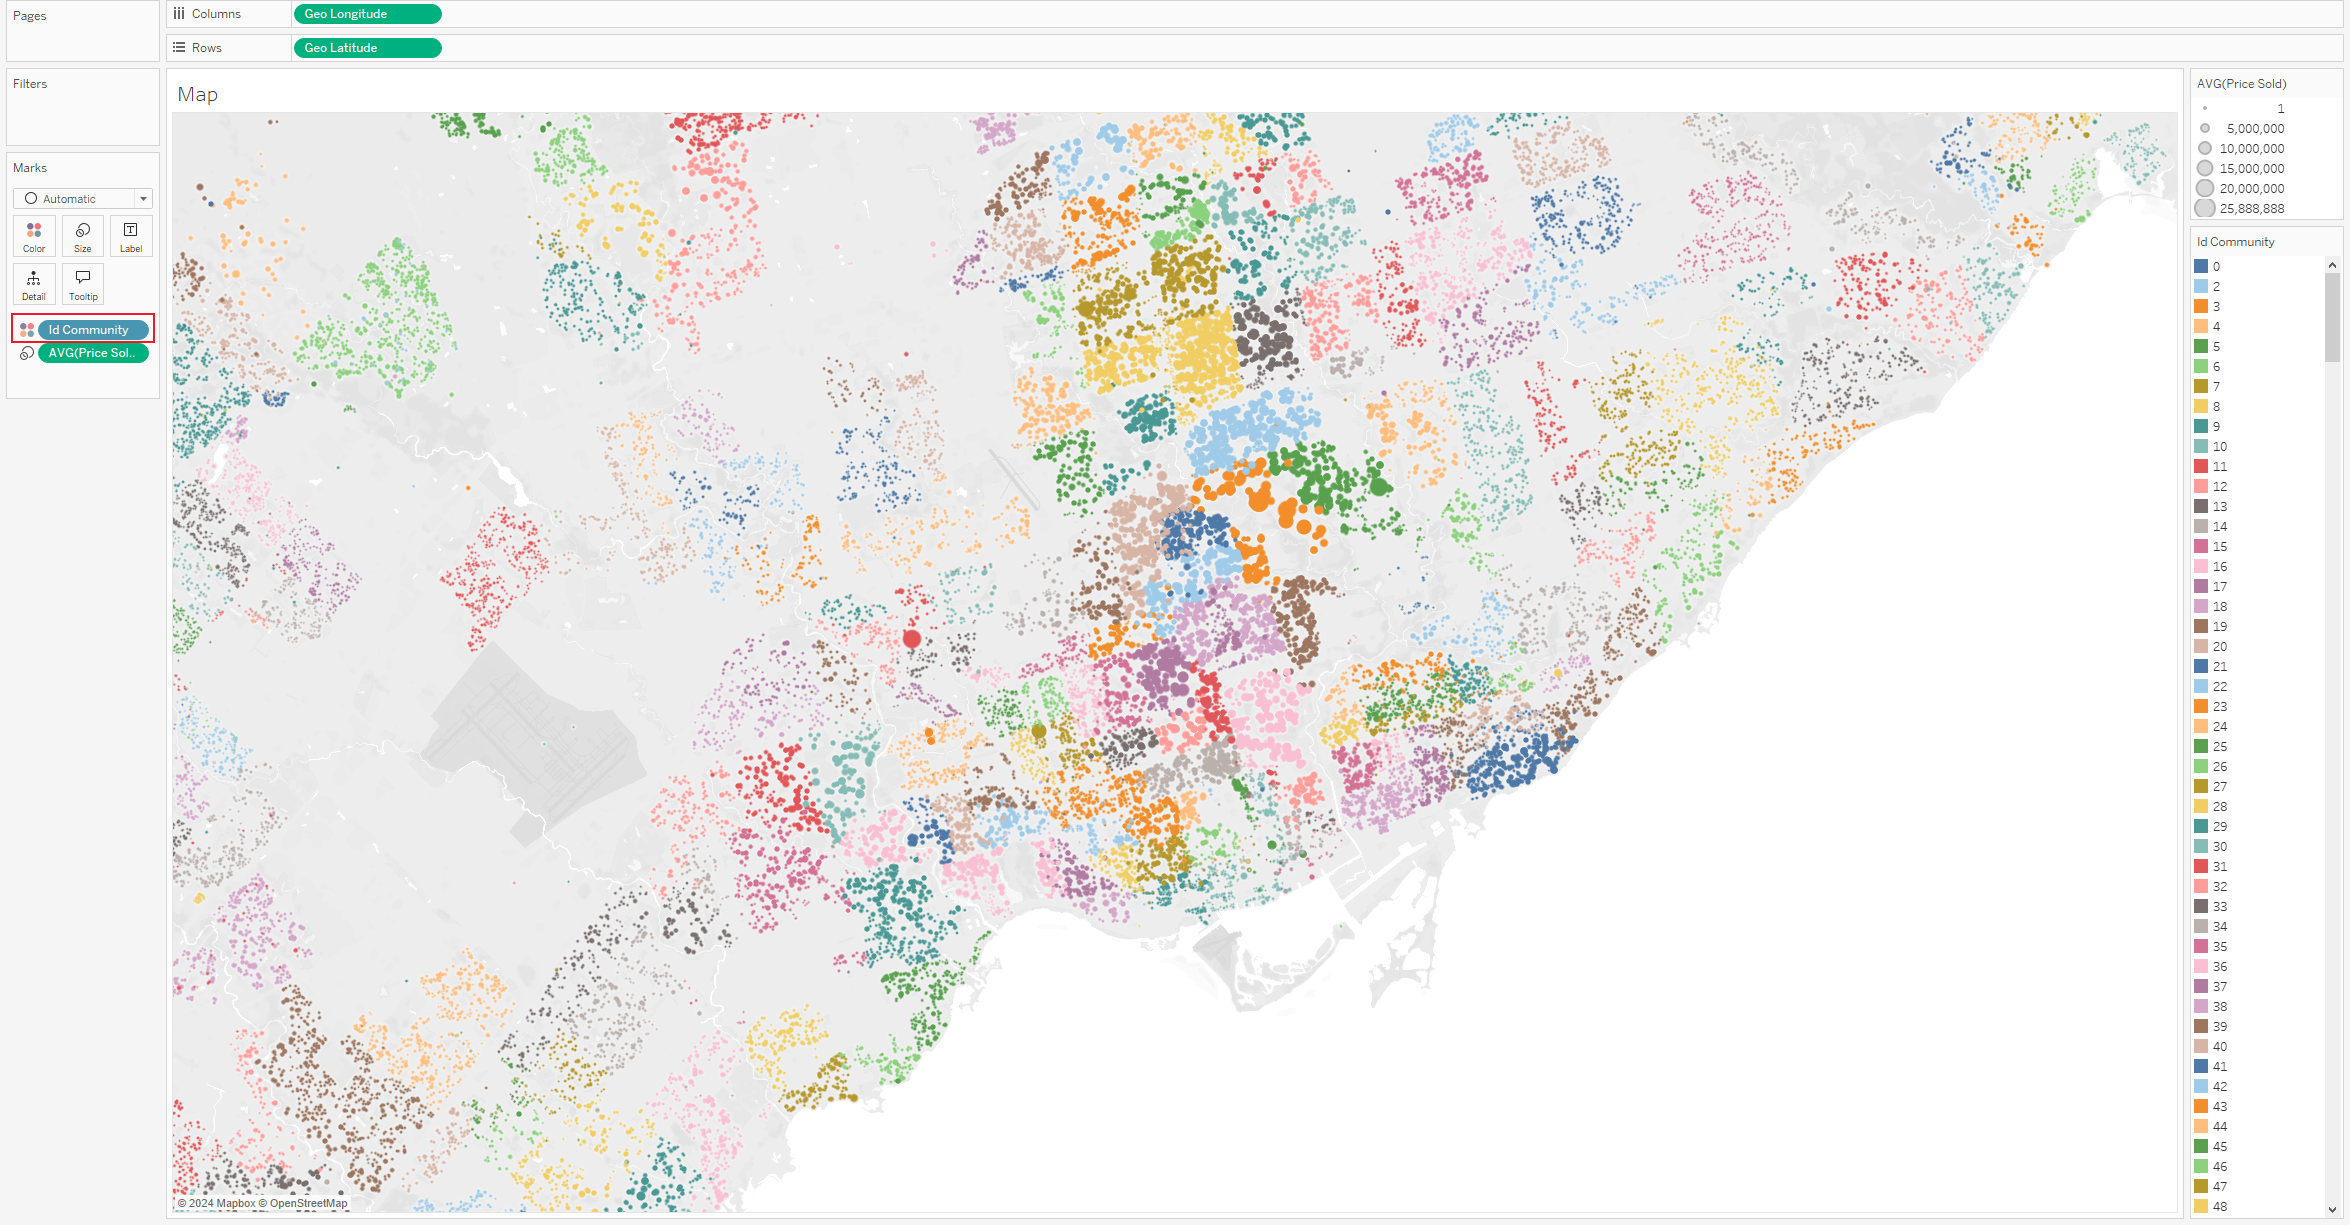</div>
- lat_long_id_municipality
<nop/> <div style="width: 1200px;">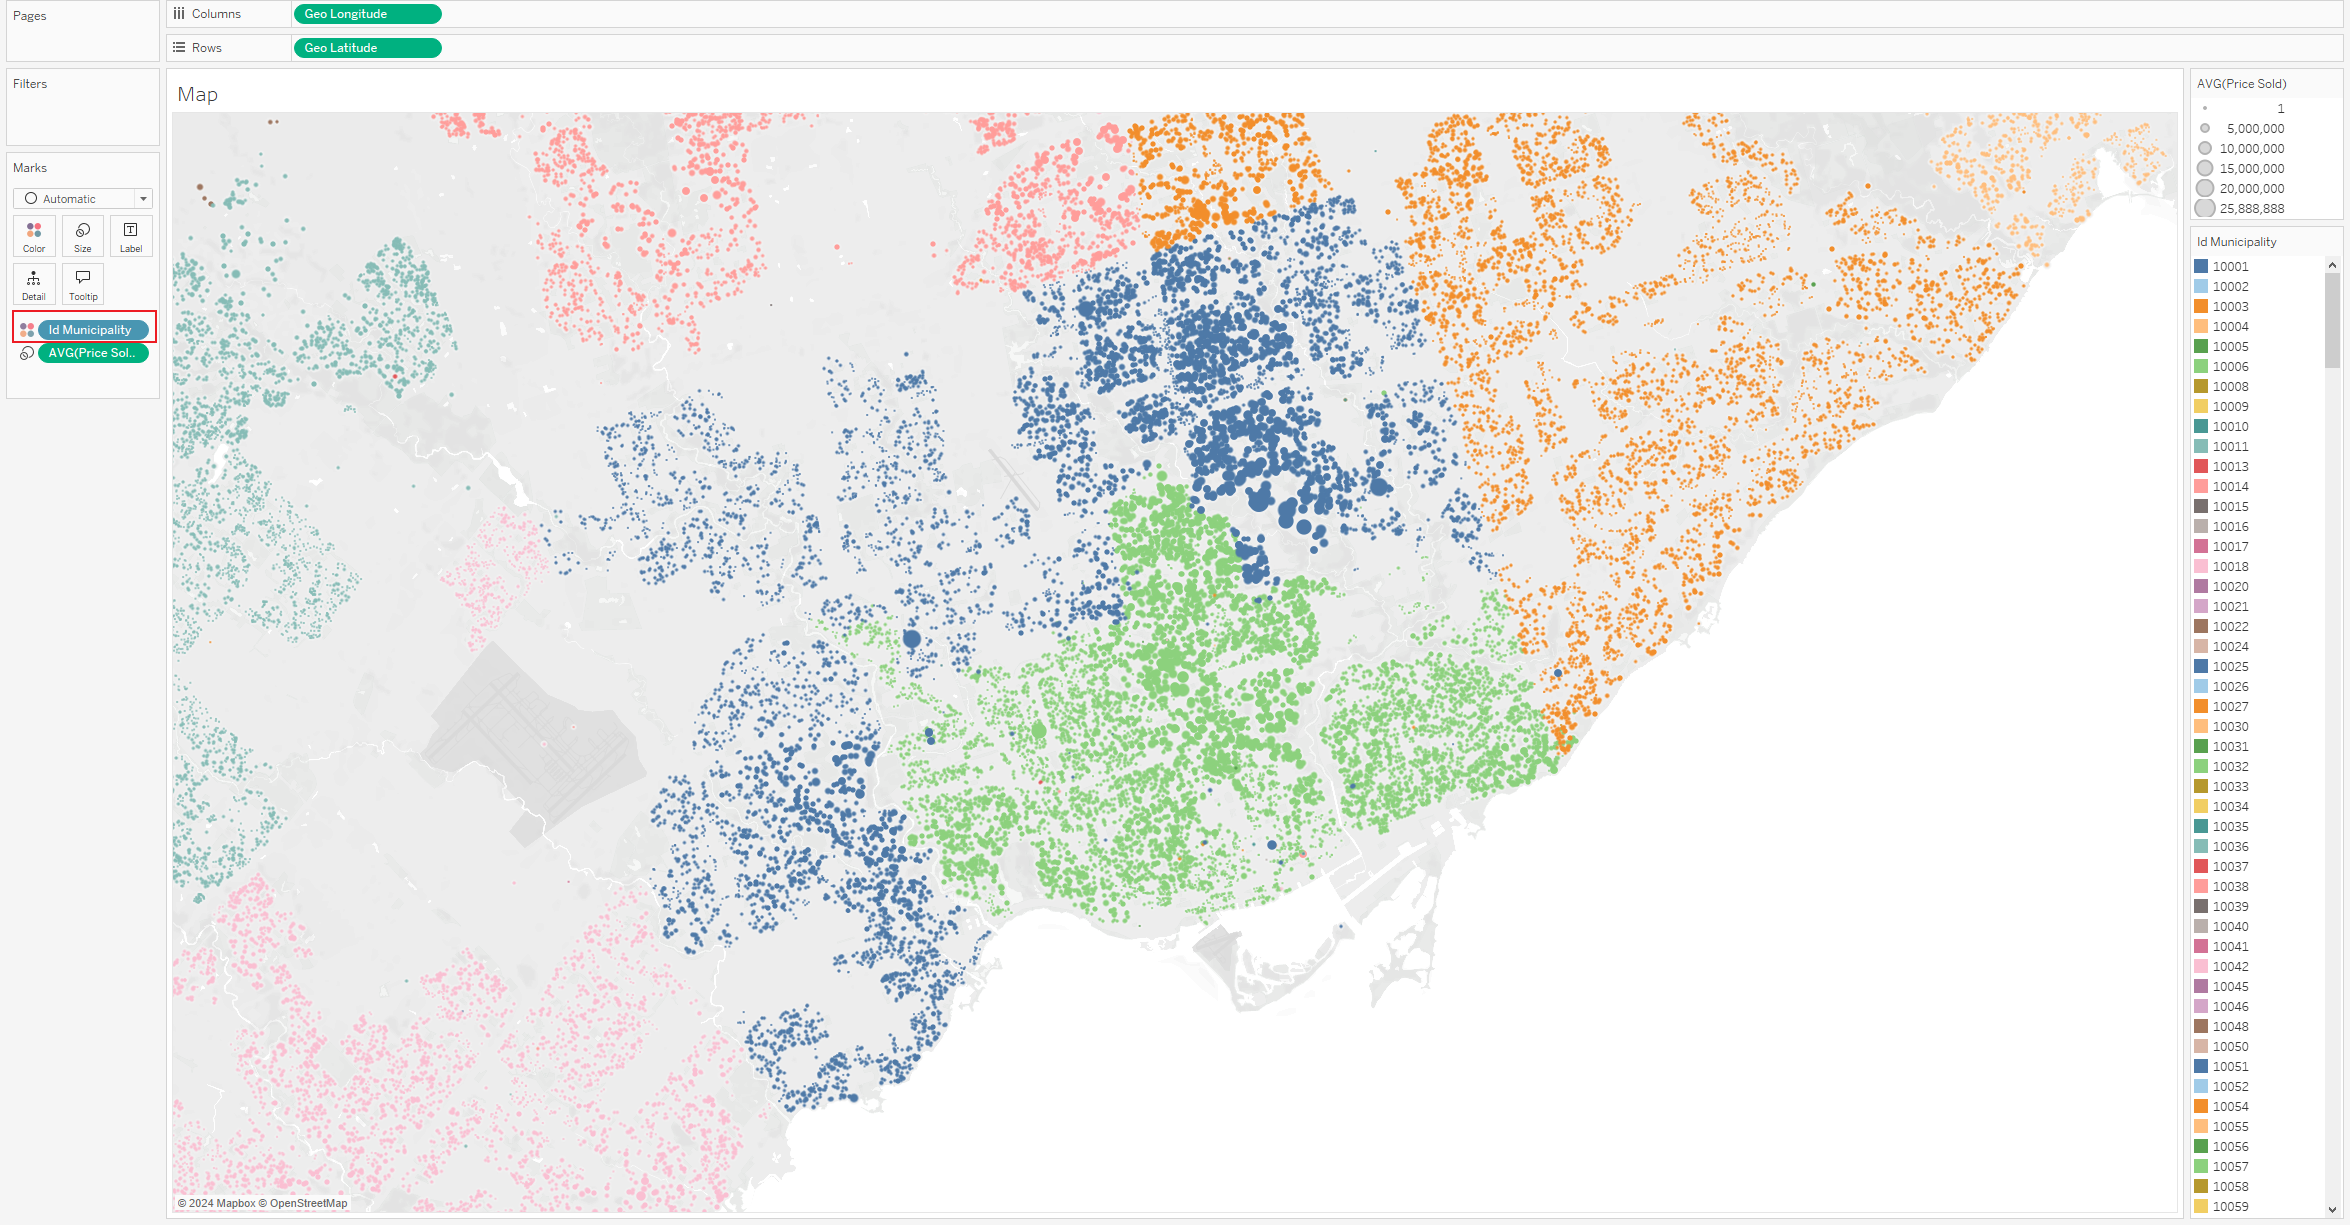</div>
- community is more useful than municipality as it is more precise

bar chart: property type count
 <nop/> <div style="width: 1200px;">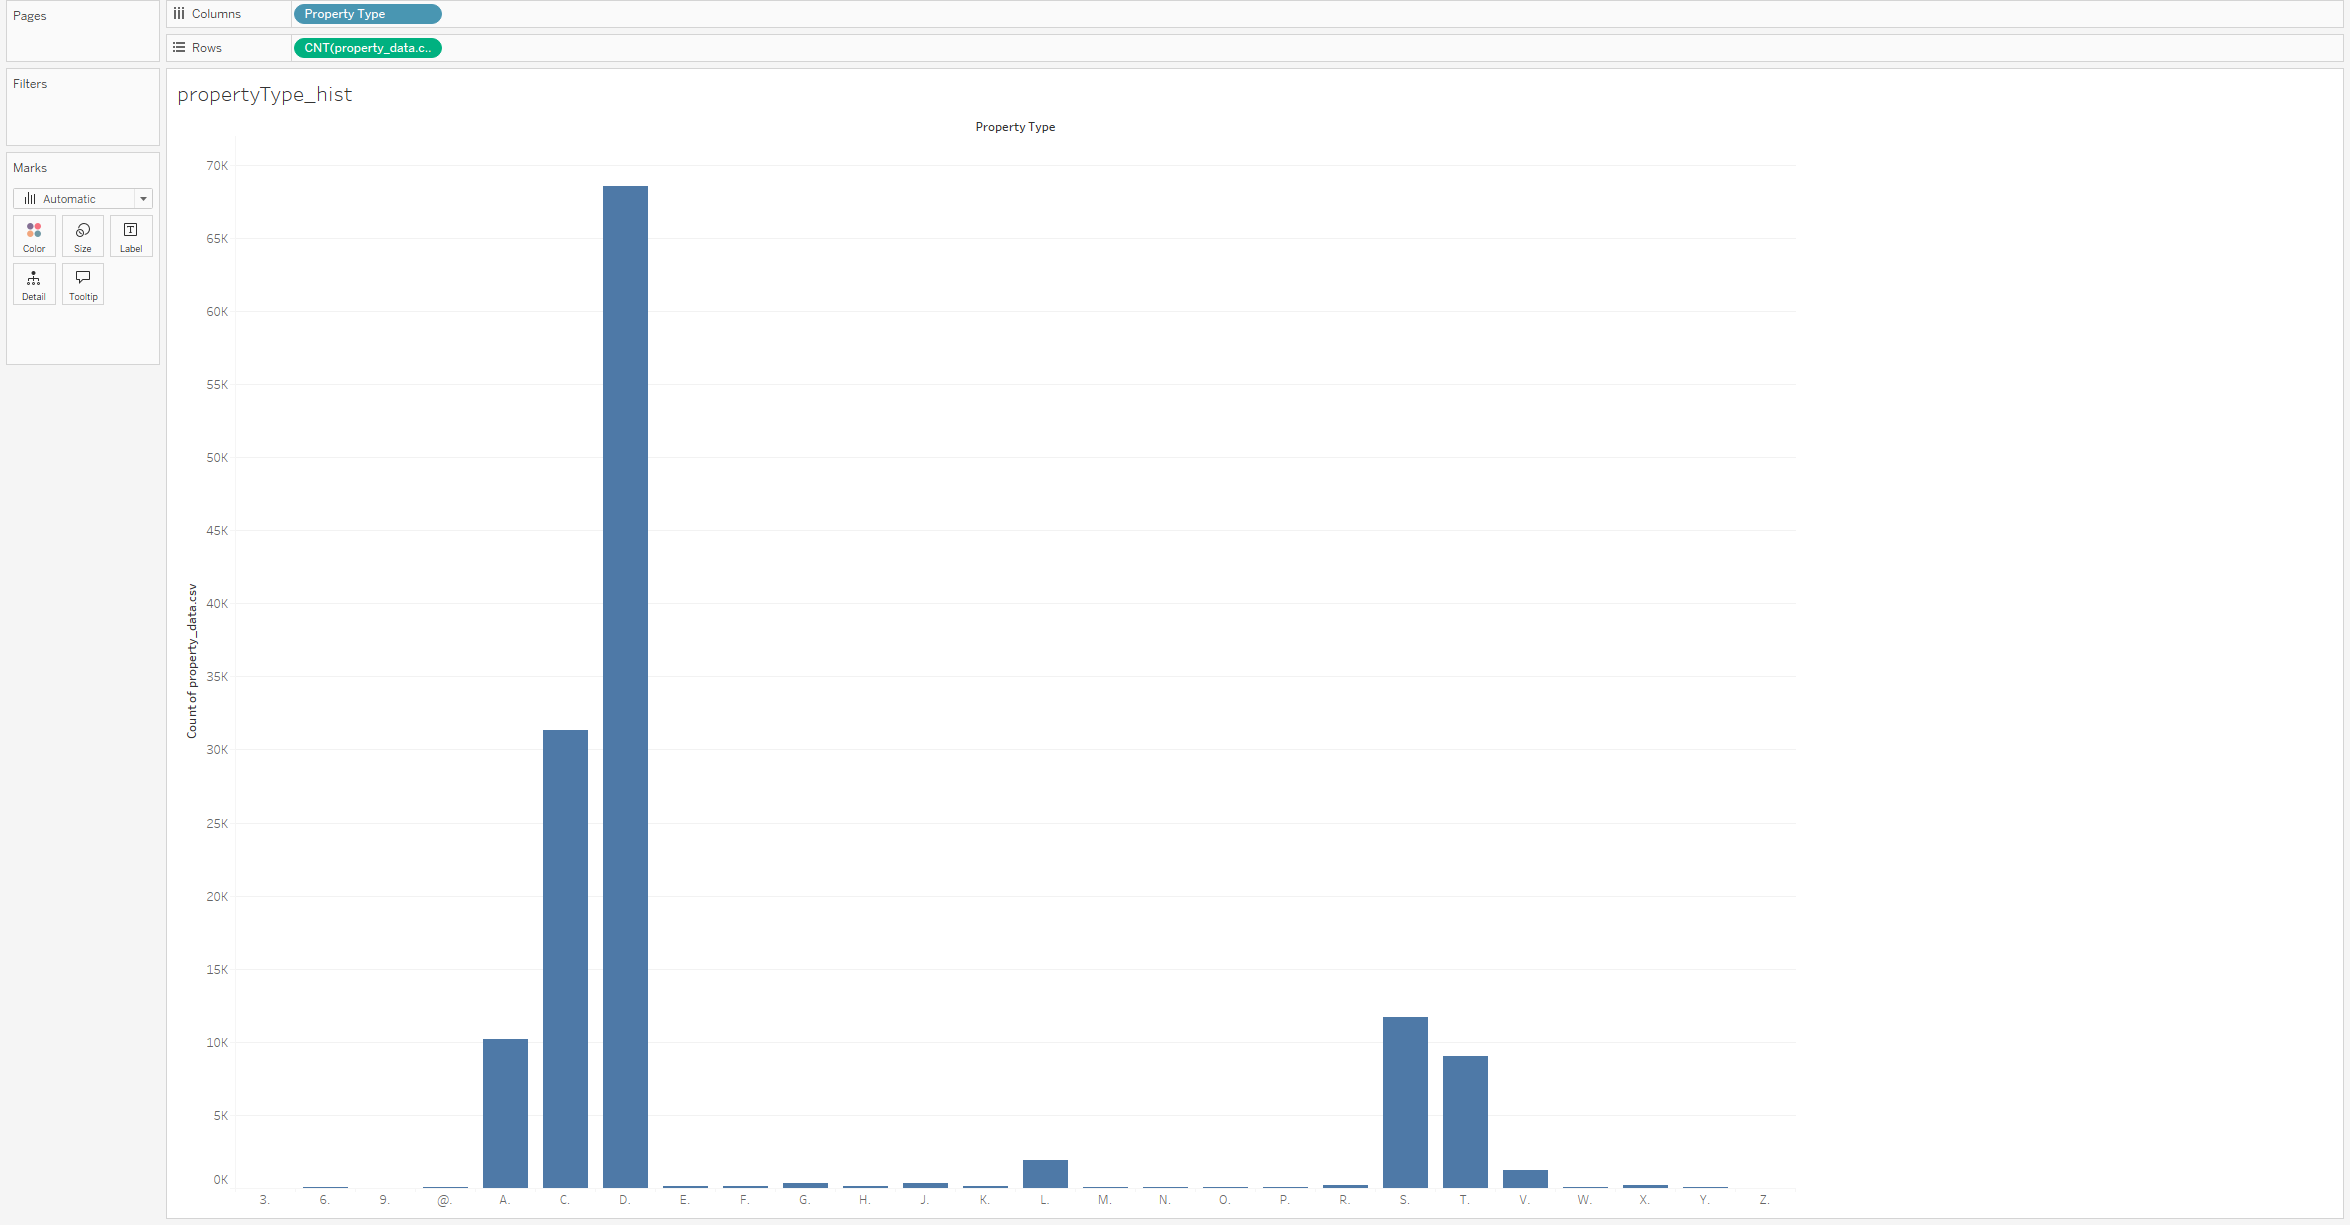</div>
- Data Imbalance: some property types have very little data
- Undersampling and/or oversampling may be necessary

box chart: yr_built-price
 <nop/> <div style="width: 1200px;">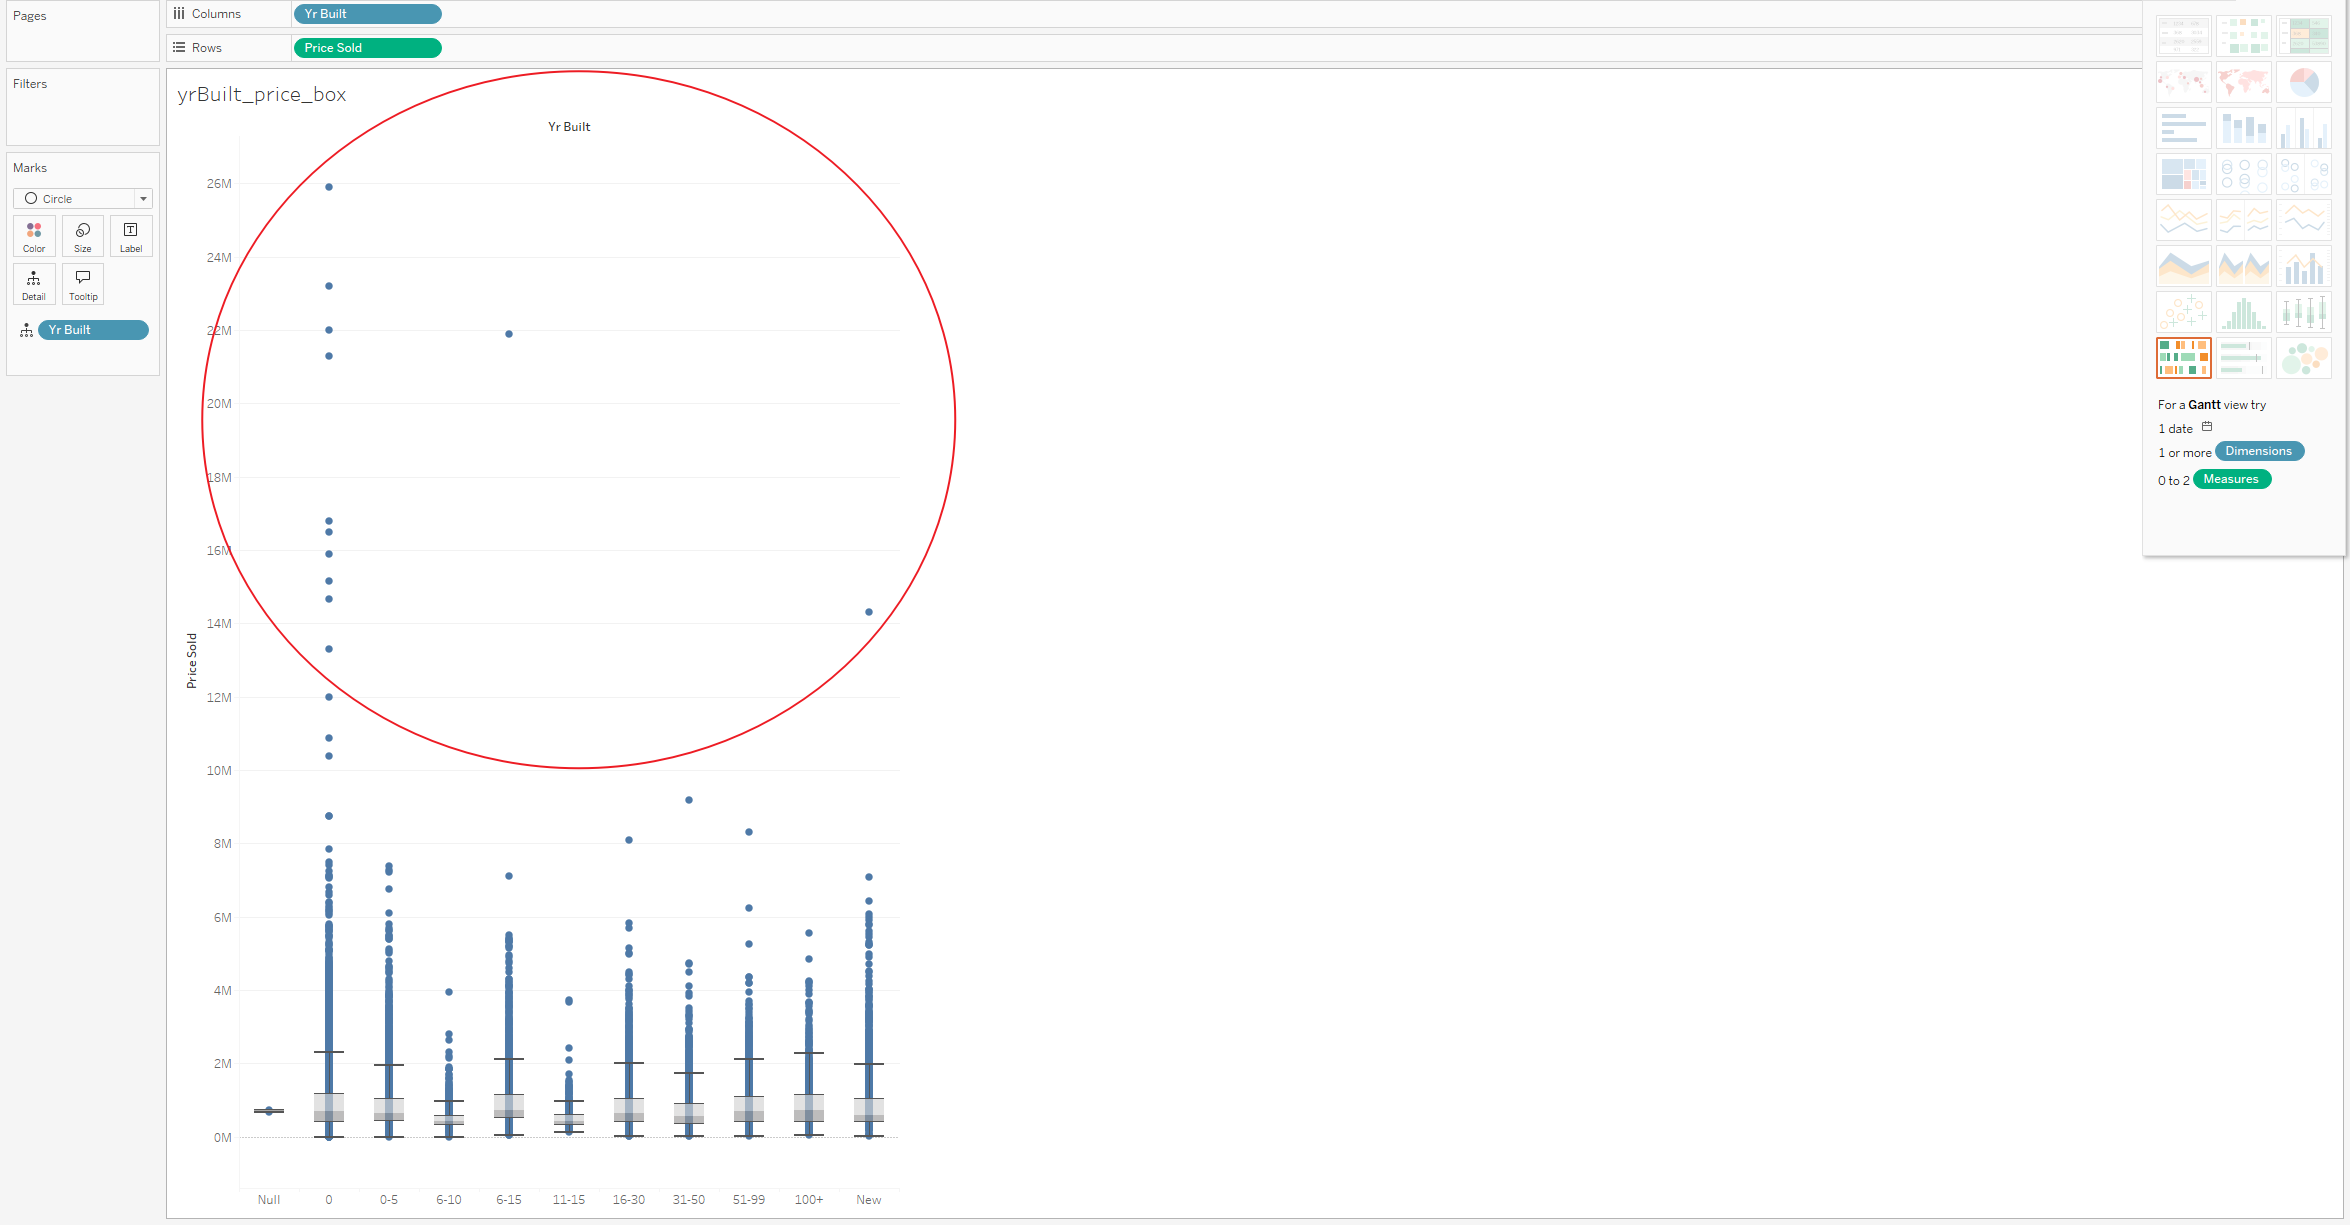</div>
- Potential outliers
- if the outliers make sense, remain. Otherwises, remove.

line chart: lp_dol-price
 <nop/> <div style="width: 1200px;">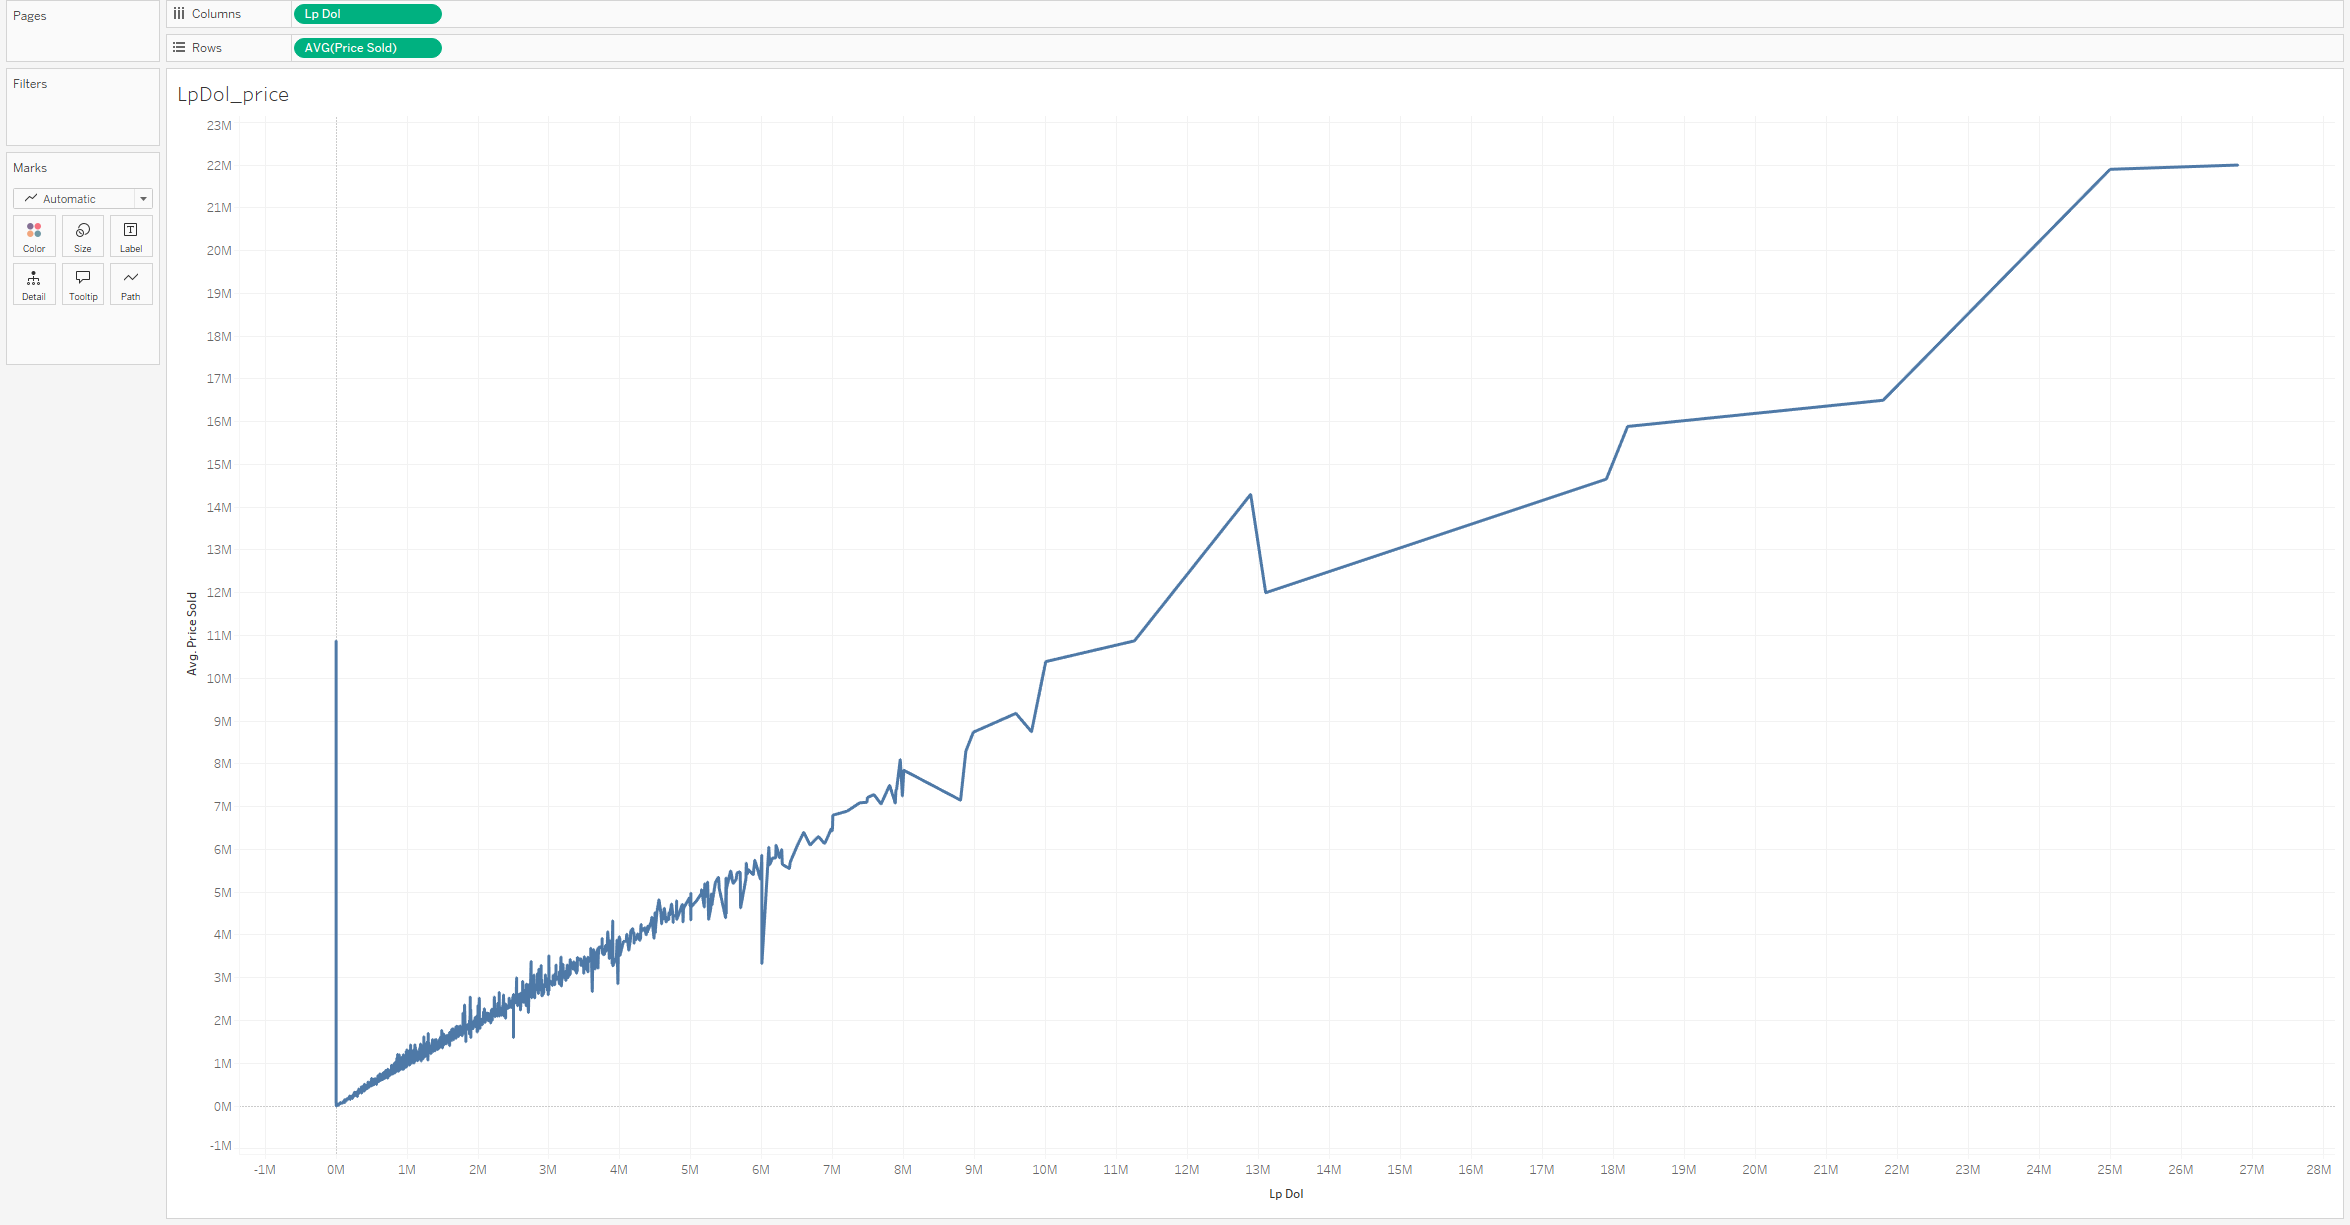</div>
- +ve correlation between lp_dol and price

In [6]:
print(f"unique str of yr_built: {property.yr_built.unique()}")

unique str of yr_built: ['New' '0' '16-30' '6-15' '0-5' '51-99' '31-50' '100+' '11-15' '6-10' nan]


yr_built: catorgorical feature
- nan: missing data? data imputation or data cleansing
- data preprocessing: New to 0
- feature engineering: cat feature to num feature? more meaningful to a ML model

### Missing data handling

In [7]:
# null checking
display(property.isnull().any())

ml_num                     False
property_type              False
br                          True
br_plus                    False
br_final                   False
bath_tot                   False
taxes                      False
lp_dol                     False
yr_built                    True
gar_type                    True
garage                     False
topHighschoolScore         False
topBelowHighschoolScore    False
geo_latitude               False
geo_longitude              False
lot_frontfeet              False
lot_depthfeet              False
lot_size                   False
sqft_numeric               False
id_community               False
id_municipality            False
date_start                 False
date_end                   False
price_sold                 False
dtype: bool

In [8]:
# br
display(property[property.br.isnull()])                 # br.isnull() while bath_tot=0 whichfillna with 0
property['br'] = property['br'].fillna(0)

ml_num property_type  br  br_plus  br_final  bath_tot    taxes  \
98      N3609979            V. NaN        0       0.0         0  4698.98   
113     X3383825            V. NaN        0       0.0         0  2100.00   
117     X3611937            V. NaN        0       0.0         0   267.84   
189     X3605027            V. NaN        0       0.0         0   494.00   
238     N3606309            V. NaN        0       0.0         0  1124.60   
...          ...           ...  ..      ...       ...       ...      ...   
133902  X3632905            V. NaN        0       0.0         0    93.00   
134622  X3637404            V. NaN        0       0.0         0   785.00   
134911  E3639577            V. NaN        0       0.0         0  2690.55   
135127  N3642464            V. NaN        0       0.0         0  1043.69   
135442  N3645889            V. NaN        0       0.0         0  2200.00   

         lp_dol yr_built gar_type  ...  geo_longitude  lot_frontfeet  \
98       699900        0      NaN  ...     -79.649690          450.0   
113      259000        0      NaN  ...     -80.140740          230.6   
117       79000        0      NaN  ...     -78.715010            0.0   
189      389900        0      NaN  ...     -80.171997            0.0   
238      150000        0      NaN  ...     -79.330271           67.5   
...         ...      ...      ...  ...            ...            ...   
133902   229900        0      NaN  ...     -79.726346            0.0   
134622   500000        0      NaN  ...     -81.616007            0.0   
134911   725000        0      NaN  ...     -79.126436           50.0   
135127   224900        0      NaN  ...     -79.955663            0.0   
135442  1988888        0      NaN  ...     -79.508916            0.0   

        lot_depthfeet    lot_size  sqft_numeric  id_community  \
98             986.00  443700.000             0           625   
113            238.47   54991.182             0           164   
117              0.00       0.000             0          1020   
189              0.00       0.000             0           195   
238            300.00   20250.000             0           744   
...               ...         ...           ...           ...   
133902           0.00       0.000             0           295   
134622           0.00       0.000             0          1151   
134911         234.00   11700.000             0           760   
135127           0.00       0.000             0           242   
135442           0.00       0.000             0           627   

        id_municipality           date_start             date_end  price_sold  
98                10160  2016-09-20 00:00:00  2016-10-17 00:00:00      675000  
113               10131  2015-12-21 00:00:00  2016-11-18 00:00:00      250000  
117               10203  2016-09-22 00:00:00  2016-10-11 00:00:00       71000  
189               10010  2016-09-14 00:00:00  2016-10-12 00:00:00      389000  
238               10117  2016-09-15 00:00:00  2016-09-29 00:00:00      145000  
...                 ...                  ...                  ...         ...  
133902            10242  2016-10-17 00:00:00  2016-11-10 00:00:00      220000  
134622            10310  2016-10-21 00:00:00  2016-10-27 00:00:00      460000  
134911            10263  2016-10-25 00:00:00  2016-11-01 00:00:00      720000  
135127            10003  2016-10-27 00:00:00  2016-11-02 00:00:00      227000  
135442            10160  2016-10-31 00:00:00  2016-11-06 00:00:00     2000000  

[1170 rows x 24 columns]

- br.isnull() while bath_tot==0 which mean br.isnull() means 0
- Therefore, fillna with 0

In [9]:
# gar_type
display(property[property.gar_type.isnull()].head().T)  # fillna with 'None'
property['gar_type'] = property['gar_type'].fillna('None')

8                    22  \
ml_num                              W3548169             E3608118   
property_type                             A.                   D.   
br                                       4.0                  3.0   
br_plus                                    1                    0   
br_final                                 4.1                  3.0   
bath_tot                                   4                    3   
taxes                                 3210.0              4994.68   
lp_dol                                635000               899000   
yr_built                                   0                    0   
gar_type                                 NaN                  NaN   
garage                                   0.0                  0.0   
topHighschoolScore                       0.3                  6.0   
topBelowHighschoolScore                  7.8                  7.2   
geo_latitude                       43.670716            43.681769   
geo_longitude                     -79.452435           -79.305477   
lot_frontfeet                           17.0                 25.5   
lot_depthfeet                          120.0                 90.0   
lot_size                              2040.0               2295.0   
sqft_numeric                               0                    0   
id_community                             108                   61   
id_municipality                        10343                10343   
date_start               2016-07-04 00:00:00  2016-09-19 00:00:00   
date_end                 2016-09-19 00:00:00  2016-09-28 00:00:00   
price_sold                            609000               976000   

                                          23                   38  \
ml_num                              E3607972             W3611393   
property_type                             D.                   D.   
br                                       4.0                  3.0   
br_plus                                    1                    0   
br_final                                 4.1                  3.0   
bath_tot                                   5                    2   
taxes                                 9414.0              2249.67   
lp_dol                               2388000               574800   
yr_built                                   0                    0   
gar_type                                 NaN                  NaN   
garage                                   0.0                  0.0   
topHighschoolScore                       6.0                  5.6   
topBelowHighschoolScore                  8.0                  3.2   
geo_latitude                       43.669695            43.730263   
geo_longitude                     -79.296445           -79.589064   
lot_frontfeet                           34.0                 45.0   
lot_depthfeet                          164.0                 89.0   
lot_size                              5576.0               4005.0   
sqft_numeric                               0                    0   
id_community                              61                  140   
id_municipality                        10343                10105   
date_start               2016-09-19 00:00:00  2016-09-22 00:00:00   
date_end                 2016-10-05 00:00:00  2016-09-24 00:00:00   
price_sold                           2250000               574800   

                                          40  
ml_num                              C3609941  
property_type                             S.  
br                                       3.0  
br_plus                                    1  
br_final                                 3.1  
bath_tot                                   2  
taxes                                 4072.8  
lp_dol                               1049000  
yr_built                                   0  
gar_type                                 NaN  
garage                                   0.0  
topHighschoolScore        

- gar_type.isnull() while garage==0 which mean gar_type.isnull() means no garage
- Therefore, fillna with 'None'

In [10]:
print(f"There are {sum(property.yr_built.isnull())} null in yr_built:")
display(property[property.yr_built.isnull()])

property = property[property.yr_built.notnull()]
print(property.shape)


There are 2 null in yr_built:


ml_num property_type   br  br_plus  br_final  bath_tot   taxes  \
70666   N3489204            D.  3.0        1       3.1         2  5229.0   
118860  X3406973            D.  4.0        1       4.1         4  4388.0   

        lp_dol yr_built  gar_type  ...  geo_longitude  lot_frontfeet  \
70666   699900      NaN      None  ...      -79.28032           0.00   
118860  688800      NaN  Built-In  ...      -79.48034          31.99   

        lot_depthfeet   lot_size  sqft_numeric  id_community  id_municipality  \
70666            0.00     0.0000             0           745            10117   
118860         114.83  3673.4117          2250           726            10216   

                 date_start             date_end  price_sold  
70666   2016-05-09 00:00:00  2016-05-16 00:00:00      725000  
118860  2016-01-28 00:00:00  2016-02-03 00:00:00      688000  

[2 rows x 24 columns]

(136117, 24)


As it just 2 rows, remove them.

In [11]:
print('Finally, checking again:')
display(property.isnull().any())

Finally, checking again:


ml_num                     False
property_type              False
br                         False
br_plus                    False
br_final                   False
bath_tot                   False
taxes                      False
lp_dol                     False
yr_built                   False
gar_type                   False
garage                     False
topHighschoolScore         False
topBelowHighschoolScore    False
geo_latitude               False
geo_longitude              False
lot_frontfeet              False
lot_depthfeet              False
lot_size                   False
sqft_numeric               False
id_community               False
id_municipality            False
date_start                 False
date_end                   False
price_sold                 False
dtype: bool

### Data preprocessing
- replace New with 0

In [12]:
property['yr_built'] = property['yr_built'].replace({'New': '0'})
property

C:\Users\RaymondLam\AppData\Local\Temp\ipykernel_23164\402682144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property['yr_built'] = property['yr_built'].replace({'New': '0'})


ml_num property_type   br  br_plus  br_final  bath_tot    taxes  \
0       N3613770            A.  4.0        0       4.0         3     0.00   
1       N3613058            D.  3.0        1       3.1         3  4025.75   
2       W3610365            D.  5.0        2       5.2         4  4103.25   
3       W3610845            S.  3.0        1       3.1         2  2573.02   
4       W3604580            D.  4.0        2       4.2         3  4180.46   
...          ...           ...  ...      ...       ...       ...      ...   
136114  S1609710            A.  3.0        1       3.1         3  3051.00   
136115  S1609709            A.  3.0        0       3.0         1  2595.00   
136116  S1609725            D.  4.0        1       4.1         4  4340.00   
136117  S1609749            D.  3.0        1       3.1         2  4100.00   
136118  E3678299            D.  3.0        0       3.0         1  4000.00   

        lp_dol yr_built  gar_type  ...  geo_longitude  lot_frontfeet  \
0       406400        0  Attached  ...     -79.857459          30.02   
1       599000        0  Built-In  ...     -79.436721          50.00   
2         1000        0  Attached  ...     -79.706485          55.13   
3       599000        0  Detached  ...     -79.476591          24.60   
4       635000        0  Attached  ...     -79.749560          56.78   
...        ...      ...       ...  ...            ...            ...   
136114  374900    16-30  Attached  ...     -79.716697          22.51   
136115  279900     6-15      None  ...     -79.641008           0.00   
136116  559000    16-30      None  ...     -79.730301           0.00   
136117  479900    16-30  Attached  ...     -79.672115           0.00   
136118  400000        0  Detached  ...     -78.692730         132.00   

        lot_depthfeet    lot_size  sqft_numeric  id_community  \
0              117.29   3521.0458          1750           232   
1              194.00   9700.0000             0           731   
2              120.00   6615.6000          1750           363   
3              120.00   2952.0000             0           105   
4              120.00   6813.6000             0           359   
...               ...         ...           ...           ...   
136114         119.23   2683.8673          1750           291   
136115           0.00      0.0000           900           288   
136116           0.00      0.0000          2750           262   
136117           0.00      0.0000           900           282   
136118         132.00  17424.0000             0           820   

        id_municipality           date_start             date_end  price_sold  
0                 10103  2016-09-25 00:00:00  2016-10-03 00:00:00      406400  
1                 10216  2016-09-21 00:00:00  2016-09-28 00:00:00      721000  
2                 10036  2016-09-21 00:00:00  2016-10-12 00:00:00      546000  
3                 10343  2016-09-21 00:00:00  2016-09-25 00:00:00      634000  
4                 10036  2016-09-14 00:00:00  2016-10-14 00:00:00      575000  
...                 ...                  ...                  ...         ...  
136114            10024  2016-12-21 00:00:00  2016-12-29 00:00:00      368000  
136115            10024  2016-12-22 00:00:00  2016-12-29 00:00:00      305000  
136116            10024  2016-12-23 00:00:00  2016-12-30 00:00:00      555000  
136117            10024  2016-12-28 00:00:00  2016-12-30 00:00:00      468000  
136118            10072  2016-12-30 00:00:00  2016-12-30 00:00:00      400000  

[136117 rows x 24 columns]

### Feature engineering
- cat feature to num feature

In [13]:
# cat feature to num feature
yr_built_str_to_int = {'16-30': 23, '6-15':10, '0-5':2, '51-99': 75, '31-50': 40, '100+': 100, '11-15': 13, '6-10': 8}
property['yr_built'] = property['yr_built'].replace(yr_built_str_to_int).astype(int)
property['yr_built']

C:\Users\RaymondLam\AppData\Local\Temp\ipykernel_23164\694249219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property['yr_built'] = property['yr_built'].replace(yr_built_str_to_int).astype(int)


0          0
1          0
2          0
3          0
4          0
          ..
136114    23
136115    10
136116    23
136117    23
136118     0
Name: yr_built, Length: 136117, dtype: int32

In [14]:
display(property[property.sqft_numeric==0].head().T)
print(f"There are {sum(property.sqft_numeric==0)} of 0 sqft")

1                    3  \
ml_num                              N3613058             W3610845   
property_type                             D.                   S.   
br                                       3.0                  3.0   
br_plus                                    1                    1   
br_final                                 3.1                  3.1   
bath_tot                                   3                    2   
taxes                                4025.75              2573.02   
lp_dol                                599000               599000   
yr_built                                   0                    0   
gar_type                            Built-In             Detached   
garage                                   1.0                  1.0   
topHighschoolScore                       7.0                  0.5   
topBelowHighschoolScore                  4.8                  3.6   
geo_latitude                       44.060296            43.687863   
geo_longitude                     -79.436721           -79.476591   
lot_frontfeet                           50.0                 24.6   
lot_depthfeet                          194.0                120.0   
lot_size                              9700.0               2952.0   
sqft_numeric                               0                    0   
id_community                             731                  105   
id_municipality                        10216                10343   
date_start               2016-09-21 00:00:00  2016-09-21 00:00:00   
date_end                 2016-09-28 00:00:00  2016-09-25 00:00:00   
price_sold                            721000               634000   

                                           4                    6  \
ml_num                              W3604580             C3610040   
property_type                             D.                   D.   
br                                       4.0                  3.0   
br_plus                                    2                    2   
br_final                                 4.2                  3.2   
bath_tot                                   3                    2   
taxes                                4180.46              3825.13   
lp_dol                                635000               958800   
yr_built                                   0                    0   
gar_type                            Attached             Attached   
garage                                   2.0                  1.0   
topHighschoolScore                       6.7                  3.9   
topBelowHighschoolScore                  4.3                  3.0   
geo_latitude                       43.736851            43.736842   
geo_longitude                      -79.74956           -79.312751   
lot_frontfeet                          56.78                 58.0   
lot_depthfeet                          120.0                128.0   
lot_size                              6813.6               7424.0   
sqft_numeric                               0                    0   
id_community                             359                   46   
id_municipality                        10036                10234   
date_start               2016-09-14 00:00:00  2016-09-20 00:00:00   
date_end                 2016-10-14 00:00:00  2016-09-27 00:00:00   
price_sold                            575000              1050000   

                                           8  
ml_num                              W3548169  
property_type                             A.  
br                                       4.0  
br_plus                                    1  
br_final                                 4.1  
bath_tot                                   4  
taxes                                 3210.0  
lp_dol                                635000  
yr_built                                   0  
gar_type                                None  
garage                                   0.0  
topHighschoolScore         

There are 46876 of 0 sqft


- sqft_numeric==0 does not make sense
- data cleansing? But there are 1/3 data with 0 sqft. Data cleansing is not a good idea.
- Data imputation with mean of property_type, id_community

### Data imputation
- sqft_numer is impossible to be 0
- replace sqft_numeric==0 with the mean sqft_numeric by property_type, id_community

In [15]:
mean_sqft_numeric = property.groupby(['property_type', 'id_community'])['sqft_numeric'].mean().reset_index().rename(columns={'sqft_numeric': 'mean_sqft_numeric'})
display(mean_sqft_numeric.head())

property = pd.merge(property, mean_sqft_numeric, on=['property_type', 'id_community'], how='left')
property.loc[property['sqft_numeric'] == 0, 'sqft_numeric'] = property.loc[property['sqft_numeric'] == 0, 'mean_sqft_numeric']
property = property[property.columns[:-1]]
property.head().T

property_type  id_community  mean_sqft_numeric
0            3.            19        1099.000000
1            3.            75         699.000000
2            3.            81         849.000000
3            3.           668         876.777778
4            3.           698         849.000000

C:\Users\RaymondLam\AppData\Local\Temp\ipykernel_23164\2870370180.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 616.55629139  280.35714286  450.72815534 ...  217.93721973 1529.16666667
  852.86069652]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  property.loc[property['sqft_numeric'] == 0, 'sqft_numeric'] = property.loc[property['sqft_numeric'] == 0, 'mean_sqft_numeric']


0                    1  \
ml_num                              N3613770             N3613058   
property_type                             A.                   D.   
br                                       4.0                  3.0   
br_plus                                    0                    1   
br_final                                 4.0                  3.1   
bath_tot                                   3                    3   
taxes                                    0.0              4025.75   
lp_dol                                406400               599000   
yr_built                                   0                    0   
gar_type                            Attached             Built-In   
garage                                   1.0                  1.0   
topHighschoolScore                       0.0                  7.0   
topBelowHighschoolScore                  5.0                  4.8   
geo_latitude                       44.316996            44.060296   
geo_longitude                     -79.857459           -79.436721   
lot_frontfeet                          30.02                 50.0   
lot_depthfeet                         117.29                194.0   
lot_size                           3521.0458               9700.0   
sqft_numeric                          1750.0           616.556291   
id_community                             232                  731   
id_municipality                        10103                10216   
date_start               2016-09-25 00:00:00  2016-09-21 00:00:00   
date_end                 2016-10-03 00:00:00  2016-09-28 00:00:00   
price_sold                            406400               721000   

                                           2                    3  \
ml_num                              W3610365             W3610845   
property_type                             D.                   S.   
br                                       5.0                  3.0   
br_plus                                    2                    1   
br_final                                 5.2                  3.1   
bath_tot                                   4                    2   
taxes                                4103.25              2573.02   
lp_dol                                  1000               599000   
yr_built                                   0                    0   
gar_type                            Attached             Detached   
garage                                   1.0                  1.0   
topHighschoolScore                       5.3                  0.5   
topBelowHighschoolScore                  3.7                  3.6   
geo_latitude                       43.726321            43.687863   
geo_longitude                     -79.706485           -79.476591   
lot_frontfeet                          55.13                 24.6   
lot_depthfeet                          120.0                120.0   
lot_size                              6615.6               2952.0   
sqft_numeric                          1750.0           280.357143   
id_community                             363                  105   
id_municipality                        10036                10343   
date_start               2016-09-21 00:00:00  2016-09-21 00:00:00   
date_end                 2016-10-12 00:00:00  2016-09-25 00:00:00   
price_sold                            546000               634000   

                                           4  
ml_num                              W3604580  
property_type                             D.  
br                                       4.0  
br_plus                                    2  
br_final                                 4.2  
bath_tot                                   3  
taxes                                4180.46  
lp_dol                                635000  
yr_built                                   0  
gar_type                            Attached  
garage                                   2.0  
topHighschoolScore         

## 2. Agent transaction data

In [16]:
agent = pd.read_csv("https://drive.usercontent.google.com/u/0/uc?id=1RipblPazdenjfa_NjW2lLIwqQIfRqv24&export=download")
agent

Id  Agent ID  Client ID    ml num  client_request_flg  \
0   1       326    6549123  X3614436                   1   
1   2       645     198466  N3615080                   1   
2   3       129    1985438  E3608118                   1   
3   4       546   21624564  W3615761                   1   

                                  client_request_msg  client_appointment_flg  \
0  I'd like to buy/sell something similar to: X36...                       1   
1  I want to book an appointment to view: [N36150...                       1   
2  I want to book an appointment to view: [E36081...                       0   
3  I want to book an appointment to view: [W36157...                       0   

   transaction_flg  
0                1  
1                0  
2                0  
3                0

- pk: id
- join key: ml_num (ml_num is not the pk as the property may be sold again in few years later)
- col rename ml num: ml_num

In [17]:
# col rename
col_rename_dict = {'Id': 'id',
                   'Agent ID': 'agent_id',
                   'Client ID': 'client_id',
                   'ml num': 'ml_num'}
agent = agent.rename(columns=col_rename_dict)
agent.columns

Index(['id', 'agent_id', 'client_id', 'ml_num', 'client_request_flg',
       'client_request_msg', 'client_appointment_flg', 'transaction_flg'],
      dtype='object')

In [18]:
print(agent.iloc[0, 5])
print(agent.iloc[1, 5])

I'd like to buy/sell something similar to: X3614436], 25 Paulvale Cres, North York
I want to book an appointment to view: [N3615080], 118 Daffodil Pl, Brampton


- client_request_msg: intention: buy/sell/appointment -> interested in the ml_num
- intent classification into 3 classes: ['buy', 'sell', 'appointment']. BERT model can solve this NLP problem.

# Train Test Split

In [19]:
property['train_test'] = np.where(property['date_end'] < '2016-11-01', 'train', 'test')

property_train = property[property.train_test=='train']
property_test = property[property.train_test=='test']
print(f"property_train: {property_train.shape}")
print(f"property_test: {property_test.shape}")

# perserve the idx
df_train_idx = property_train.index
df_test_idx = property_test.index

property_train: (119902, 25)
property_test: (16215, 25)


# K-Means Clustering
- To cluster the properties (ml_num) which are similar

In [20]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans

## Encode for cat features
- one-hot encode (not suggested): the result sparse matrix would be slow in for loop finding the n_cluster using elbow method in kmeans
- label encode (not suggested): cannot handle unknown values in test set
- Ordinal encode: can handle unknown values in test set (-1)

In [21]:
# Ordinal encode
df_cat_train = property_train[cat_features].copy()
df_cat_test = property_test[cat_features].copy()

for col in cat_features:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    # Fit on the train set and transform both train and test sets
    df_cat_train[[col]] = encoder.fit_transform(property_train[[col]])
    df_cat_test[[col]] = encoder.transform(property_test[[col]])

print(f"df_cat_train: {df_cat_train.shape}")
print(f"df_cat_test: {df_cat_test.shape}")

df_cat_train: (119902, 4)
df_cat_test: (16215, 4)


## Standardize the num features

In [22]:
# Standardize the num features
scaler = StandardScaler()
# Fit on the train set and transform both train and test sets
df_num_train = pd.DataFrame(scaler.fit_transform(property_train[num_features]), columns=num_features, index=df_train_idx)
df_num_test = pd.DataFrame(scaler.transform(property_test[num_features]), columns=num_features, index=df_test_idx)

print(f"df_num_train: {df_num_train.shape}")
print(f"df_num_test: {df_num_test.shape}")

df_num_train: (119902, 13)
df_num_test: (16215, 13)


In [23]:
df_train = pd.concat([df_cat_train, df_num_train], axis=1)
df_test = pd.concat([df_cat_test, df_num_test], axis=1)
print(f"df_train: {df_train.shape}")
print(f"df_test: {df_test.shape}")

df_train: (119902, 17)
df_test: (16215, 17)


## Elbow method to find the n_clusters

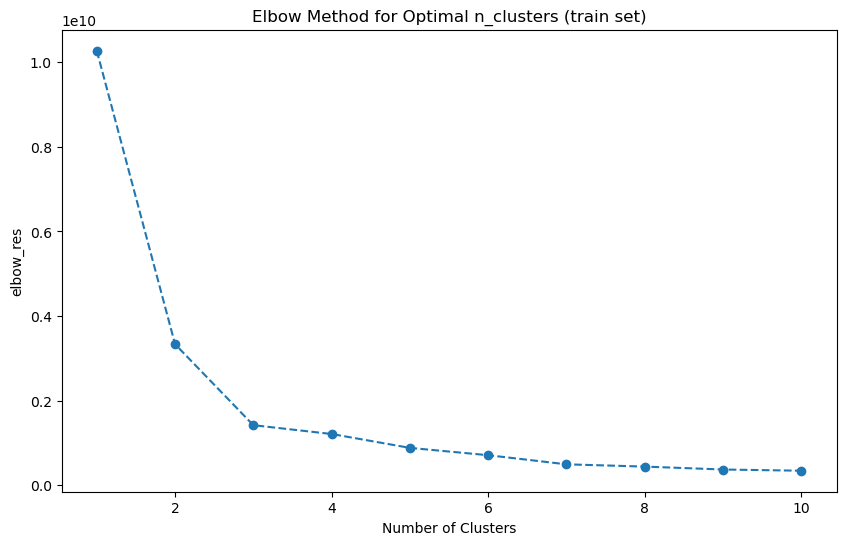

In [24]:
# Use Elbow method to find the n_clusters (train set)
elbow_res = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=SEED)
    kmeans.fit(df_train)
    elbow_res.append(kmeans.inertia_)

# plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), elbow_res, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal n_clusters (train set)')
plt.xlabel('Number of Clusters')
plt.ylabel('elbow_res')
plt.show()

In [25]:
# Therefore, n_cluster=3
kmeans = KMeans(n_clusters=3, random_state=SEED)
cluster_train = kmeans.fit_predict(df_train)
cluster_test = kmeans.predict(df_test)
print(f"cluster_train: {cluster_train.shape}")
print(f"cluster_test: {cluster_test.shape}")

cluster_train: (119902,)
cluster_test: (16215,)


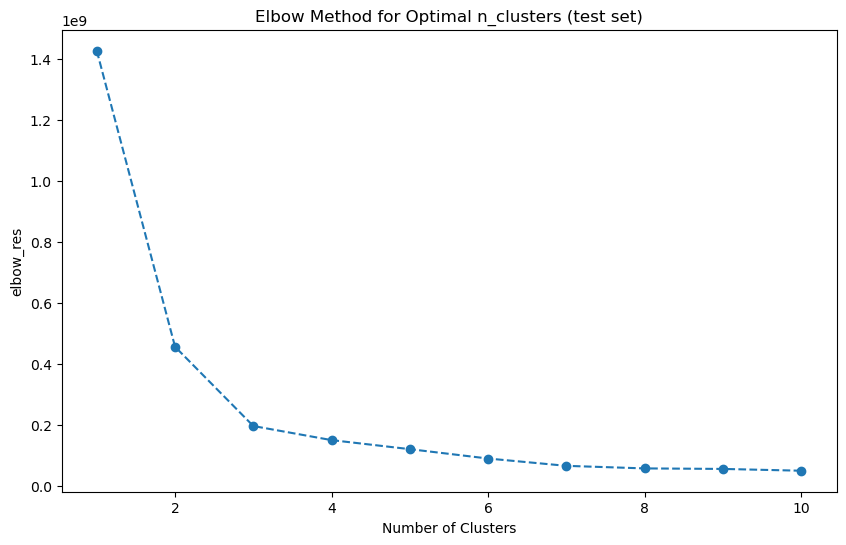

In [26]:
# Kmeans evaluation on test set
elbow_res=[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=SEED)
    kmeans.fit(df_test)
    elbow_res.append(kmeans.inertia_)

# plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), elbow_res, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal n_clusters (test set)')
plt.xlabel('Number of Clusters')
plt.ylabel('elbow_res')
plt.show()

In [27]:
property_train['cluster'] = cluster_train
property_test['cluster'] = cluster_test
cluster_full = pd.concat([property_train['cluster'], property_test['cluster']], axis=0)
property['cluster'] = cluster_full
property

C:\Users\RaymondLam\AppData\Local\Temp\ipykernel_23164\3114383553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_train['cluster'] = cluster_train
C:\Users\RaymondLam\AppData\Local\Temp\ipykernel_23164\3114383553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_test['cluster'] = cluster_test


ml_num property_type   br  br_plus  br_final  bath_tot    taxes  \
0       N3613770            A.  4.0        0       4.0         3     0.00   
1       N3613058            D.  3.0        1       3.1         3  4025.75   
2       W3610365            D.  5.0        2       5.2         4  4103.25   
3       W3610845            S.  3.0        1       3.1         2  2573.02   
4       W3604580            D.  4.0        2       4.2         3  4180.46   
...          ...           ...  ...      ...       ...       ...      ...   
136112  S1609710            A.  3.0        1       3.1         3  3051.00   
136113  S1609709            A.  3.0        0       3.0         1  2595.00   
136114  S1609725            D.  4.0        1       4.1         4  4340.00   
136115  S1609749            D.  3.0        1       3.1         2  4100.00   
136116  E3678299            D.  3.0        0       3.0         1  4000.00   

        lp_dol  yr_built  gar_type  ...  lot_depthfeet    lot_size  \
0       406400         0  Attached  ...         117.29   3521.0458   
1       599000         0  Built-In  ...         194.00   9700.0000   
2         1000         0  Attached  ...         120.00   6615.6000   
3       599000         0  Detached  ...         120.00   2952.0000   
4       635000         0  Attached  ...         120.00   6813.6000   
...        ...       ...       ...  ...            ...         ...   
136112  374900        23  Attached  ...         119.23   2683.8673   
136113  279900        10      None  ...           0.00      0.0000   
136114  559000        23      None  ...           0.00      0.0000   
136115  479900        23  Attached  ...           0.00      0.0000   
136116  400000         0  Detached  ...         132.00  17424.0000   

        sqft_numeric  id_community  id_municipality           date_start  \
0        1750.000000           232            10103  2016-09-25 00:00:00   
1         616.556291           731            10216  2016-09-21 00:00:00   
2        1750.000000           363            10036  2016-09-21 00:00:00   
3         280.357143           105            10343  2016-09-21 00:00:00   
4         450.728155           359            10036  2016-09-14 00:00:00   
...              ...           ...              ...                  ...   
136112   1750.000000           291            10024  2016-12-21 00:00:00   
136113    900.000000           288            10024  2016-12-22 00:00:00   
136114   2750.000000           262            10024  2016-12-23 00:00:00   
136115    900.000000           282            10024  2016-12-28 00:00:00   
136116    852.860697           820            10072  2016-12-30 00:00:00   

                   date_end  price_sold  train_test  cluster  
0       2016-10-03 00:00:00      406400       train        2  
1       2016-09-28 00:00:00      721000       train        1  
2       2016-10-12 00:00:00      546000       train        2  
3       2016-09-25 00:00:00      634000       train        0  
4       2016-10-14 00:00:00      575000       train        2  
...                     ...         ...         ...      ...  
136112  2016-12-29 00:00:00      368000        test        2  
136113  2016-12-29 00:00:00      305000        test        2  
136114  2016-12-30 00:00:00      555000        test        2  
136115  2016-12-30 00:00:00      468000        test        2  
136116  2016-12-30 00:00:00      400000        test        1  

[136117 rows x 26 columns]

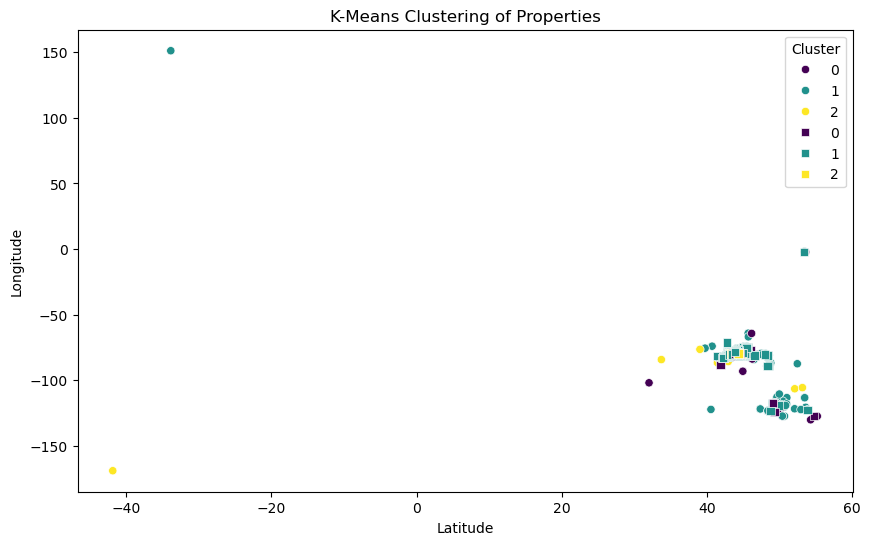

In [28]:
# Plot the clusters
plt.figure(figsize=(10, 6))

# Plot train data with one marker
sns.scatterplot(x='geo_latitude', y='geo_longitude', hue='cluster', data=property_train, palette='viridis', marker='o')

# Plot test data with a different marker
sns.scatterplot(x='geo_latitude', y='geo_longitude', hue='cluster', data=property_test, palette='viridis', marker='s')

plt.title('K-Means Clustering of Properties')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(title='Cluster')
plt.show()

# Candidate Generation
- Now, we have 3 clusters of properties.
- The Kmeans clustering method reduced the multi dimensions of features (cat_features + num_features) into 1 dimension (cluster).
- When a client is viewing a property on HouseSigma, the trained Kmeans can instantly identify the property into a specific cluster.
- Within this cluster, a list of candidates (agents) with successful transcations can be founded.
- Therefore, the candidate generation process is completed.

- Supposed the agent table was a full table
- In order to find a list of candidates (agents) with successful transcations
- Construct a table showing property-agent interaction: property data inner join agent data 
- This will explode the table because agent table has multiple nonunique properties (ml_num).
- In addition, as we only focus on successfull transactions (transaction_flg==1)
- filtering on agent table before joining is necessary

In [29]:
# filtering on agent table before joining
temp = property.merge(agent[agent.transaction_flg==1], on=['ml_num'], how='inner')
temp = temp[['ml_num', 'cluster', 'agent_id', 'client_appointment_flg', 'transaction_flg']]
temp

ml_num  cluster  agent_id  client_appointment_flg  transaction_flg
0  X3614436        2       326                       1                1

# Candidate Retrieval
- Let's say a client is viewing a property on HouseSigma.
- The trained Kmeans can instantly identify the property as cluster 2.
- Find the argmax(total_transactions) of agent_id in the cluster 2.
- The top 1 agent is going to be recommended to the client viewing this property which is belong to cluster 2.

In [30]:
temp = temp[temp.cluster==2]

rank_temp = temp.groupby(['cluster','agent_id'])['transaction_flg'].sum().reset_index().rename(columns={'transaction_flg': 'total_transactions'})
rank_temp.sort_values(['cluster', 'total_transactions'], ascending=False)

cluster  agent_id  total_transactions
0        2       326                   1

- Actually, we could stop here. 
- This method utilize Kmeans clustering method to group the similar properties into clusters.
- Rank the agents by total_transactions and select the top1 agent for recommendation.
- This is a simple method but does not provide a tailored recommendation for each client.
    - For example, the downside of this simple method is always recommending the same agent for cluster2.
- To give a personalized recommendation, we can conduct client-agent scoring matrices and user-based collaborative filtering.

# Hybrid method: Content-based filtering + User-based collaborative filtering
## 0. Client-Agent Scoring Matrices
- Instead of just focusing on successful transcations (transaction_flg==1)
- We also consider appointment (client_appointment_flg==1) and formulate a score where {appointment: 1, transaction: 10}

In [31]:
mat = property.merge(agent[(agent.client_appointment_flg==1) | (agent.transaction_flg==1)], on=['ml_num'], how='inner')
mat = mat[['client_id', 'ml_num', 'cluster', 'agent_id', 'client_appointment_flg', 'transaction_flg']]
mat['transaction_flg'] = mat['transaction_flg'].replace({1:10})

# Calculate the score
mat = mat.groupby(['client_id', 'cluster','agent_id'])[['client_appointment_flg', 'transaction_flg']].sum().reset_index().rename(columns={'client_appointment_flg':'total_appointments', 'transaction_flg': 'total_transactions'})
mat['score'] = mat.total_appointments + mat.total_transactions
mat = mat[['client_id', 'cluster', 'agent_id', 'score']]

# pivot
mat = mat.pivot_table(index=['cluster', 'client_id'], columns=['agent_id'], values=['score'], aggfunc='sum').fillna(0)
mat

score     
agent_id            326  645
cluster client_id           
1       198466      0.0  1.0
2       6549123    11.0  0.0

- Finally ,we have 1 matrix for each cluster. (3 Clusters: 3 matrices)
- A matrix is consisted of numerous clients in rows and numerous agents in cols while the value is the score.

## 1. Content-based filtering [Candidate Generation]
- narrow down the scope of candidates and generate a list of candidates which is similar to the target clients
- e.g. A client (target client) is viewing a property which belong to cluster2 -> content-based filtering (cluster==2) -> Calculate the similarities between the target client and other clients in matrix2.

## 2. User-based collaborative filtering [Candidate Retrieval]
- Conduct user-based collaborative filtering to suggest an agent to the client according to the other user's perference.
    - From the list of candidates, select few candidates (k) who is the most similar to the target client's perference.
    - e.g. The target client shares similar interest with client Z according the Client-Agent scoring matrix (The scores between them are similar).
- How to measure the similarity? Cosine Similarity (user-based: row-wise)


### 2a. Cosine Similarity (user-based: row-wise)

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_mat = pd.DataFrame(cosine_similarity(mat), index=mat.index, columns=mat.columns)
similarity_mat

score     
agent_id            326  645
cluster client_id           
1       198466      1.0  0.0
2       6549123     0.0  1.0

### 2b. Rank and select top k agent(s)
- set a similarity threhold (e.g. similarity<0.5 would not be recommended)
- Rank the similarity desc 
- select the top k agent(s) for recommendations

In [33]:
similarity_threshold =  0.5
k=1

# similarity_matrix for cluster1
similarity_mat1 = similarity_mat.loc[1]
# unpivot
similarity_mat1 = similarity_mat1.melt(ignore_index=False, value_name='score1')
display(similarity_mat1)

print(f"Recommend agent_id: {similarity_mat1[similarity_mat1.score1>similarity_threshold]['agent_id'][:k].values[0]} to the client_id: {similarity_mat1[similarity_mat1.score1>similarity_threshold].index[:k].values[0]} viewing the property belonging to cluster1")

None  agent_id  score1
client_id                         
198466     score       326     1.0
198466     score       645     0.0

Recommend agent_id: 326 to the client_id: 198466 viewing the property belonging to cluster1


# Conclusion
- The advantages of using Hybrid method: Content-based filtering + User-based collaborative filtering
    - Instead of the simple way which always recommends the same agent for the properties belonging to the same cluster
    - this method recommends personalized agent(s) to different clients even when they are browsing the same property
    - It would enhance user experience on HouseSigma website and app and increase conversion rates by suggesting relevant agents to clients
- As the data size is relatively small now, model-based recommendation engine would have more advantages if the data size is going bigger.

# Edge Case Handling
Potential Problem:
- This hybrid method might suffer from an issue where the model frequently recommends the same agents due to similar client preference vectors
- leading to an imbalance in workload and business opportunities for agents.

Solutions:
- add penalties to the agents who were too frequently recommended in the cosine similarity
- add penalties to the agents who currently have too high workloads in the similarity metrics

# Improvement
- incoporate client's profile data
    - client's race would be an important features
- introduce a feedback loop
    - Based on the feedback, the system can adjust the scores in the matrics.
    - e.g. if a recommended agent with a high similarity score is frequently rejected by the client, the system might lower the score of the agent.
    - then regularly retrain the model (re-compute the matrices and the similarities)
- hyperparameters tuning
    - n_clusters (Kmeans)
    - scoring formula {appointment:1, transaction:20}?
    - top k agents
- POC of using model-based recommendation engine (when data size grow bigger)
    - NN: Neural Collaborative Filtering
    - RNN: predict the next agent a user might interact with based on their interaction history

# Evaluation
## 1. Offline Evaluation
### Offline Metric
- Precision: particularly important when the cost of presenting irrelevant items is high which is our recommendation case
- Why not recall and f1 score?
    - recall: particularly important when it is important to cover as many relevant items as possible. Our recommendation engine only recommend top k agent(s) which will never cover all the positive cases.
    - f1 score: precision is more important than recall in this case.

### Cross-Validation
- Not suggested in our case. Effort is large while impact is small (probably have another similar value of the orginal precision).
- In addition, online metric is far more important than the offline metric.

## 2. Online Evaluation
### A/B Testing
- Test Group: randomly assign
    - Control group: current recommendation system
    - Test group: new system
- Online Metrics: conversion rate (successful transaction)
    - why not click-through rate?
    - definition of positive: successful transaction
- Duration and Sample Size:
    - Duration of the test: 2 months
        - as the process of buying/selling a property is normally around 1 month
    - Sample size: 500 clients for each group
        - large enough to be statistically significant.
        - original conversion rate maybe 10% -> expected value > 50 successfully transactions

## 3. Live Production Monitoring
### Real-time Dashboard
- Establish a real-time dashboard to monitor the live precision
- But the downside is the delay problem: we have to wait probably 1 month for the client to complete transaction so that we can have the true label

### Feedback Loop
- Establish a mechanism to collect clients' feedback and continuously feeding this information back into the system to improve its recommendations.

### Retrain model
- Retrain the model when the real-time dashboard or feedback loop show a drop in precision or enormous rejected suggestions by clients.

# 4. Phased Launch Plan
- Phase 1: Build the benchmark
    - Start with simple content-based filtering
    - And conduct simple enhancements, such as improving data quality, implement QA rules to secure the data quality. 
    - This can build a solid foundation as a promising benchmark.
- Phase 2: Advanced models
    - Introduce more sophisticated models, such as hybrid recommendation systems that combine content-based filtering and user-based collaborative filtering. 
    - Experiment with different algorithms, conduct hyperparameters tuning and result analysis to determine the best fit for the data.
- Phase 3: Model Improvements
    - Incoroprate more domain of data to enrich the features for the model such as client's profile data
- Phase 4: Continuous Improvements
    - Focus on MLOps such as establishing a pipeline of feedback loop, data drift detection and model auto retrain. 
    - This ensures the recommendation engine evolves with changing user preferences and market conditions.